# Fast brain decoding with random sampling and random projections #

**Andres HOYOS-IDROBO**, Gael VAROQUAUX and Bertrand THIRION

[PARIETAL TEAM](https://team.inria.fr/parietal/), INRIA, CEA, University Paris-Saclay

**Presented on:** the 6th International workshop on Pattern Recognition in Neuroimaging(PRNI) 2016. Trento, Italy

[link to the paper](https://hal.inria.fr/hal-01313814/document)

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nilearn.input_data import NiftiMasker

/home/ahoyosid/anaconda2/envs/develop/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Testing on Haxby 2001, discriminating between faces and places ##

In [2]:
# Fetching haxby dataset
from nilearn import datasets
data_files = datasets.fetch_haxby(n_subjects=1)

masker = NiftiMasker(smoothing_fwhm=4, standardize=True, mask_strategy='epi',
                     memory='cache', memory_level=1)

labels = np.recfromcsv(data_files.session_target[0], delimiter=" ")

# Restrict to face and house conditions
target = labels['labels']
condition_mask = np.logical_or(target == b"face", target == b"house")

# Split data into train and test samples, using the chunks
condition_mask_train = np.logical_and(condition_mask, labels['chunks'] <= 6)
condition_mask_test = np.logical_and(condition_mask, labels['chunks'] > 6)

X_masked = masker.fit_transform(data_files['func'][0])
X_train = X_masked[condition_mask_train]
X_test = X_masked[condition_mask_test]
y_train = target[condition_mask_train]
y_test = target[condition_mask_test]

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer(pos_label=1, neg_label=-1)
y_train = lb.fit_transform(y_train).ravel()
y_test = lb.transform(y_test).ravel()

## Prediction using the whole brain (non-reduced) ##

In [3]:
# Fit model on train data and predict on test data
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(Cs=10, penalty='l2')

ti = time.time()
clf.fit(X_train, y_train)
to_raw = time.time() - ti

y_pred = clf.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.

raw_coef = masker.inverse_transform(clf.coef_)

print("classification accuracy : %g%%,  time %.4fs" % (accuracy, to_raw))

classification accuracy : 98.8889%,  time 5.4279s


## Prediction on reduced data: adding Nystrom method ##

In [4]:
from sklearn.kernel_approximation import Nystroem


class LinearNistroem(Nystroem):
    """We are using a linear kernel only and adding the invertion method.
    
    Parameters
    -----------
    n_components: int, the number of components should be at most n
    random_state: int, the random seed (optional)
    """

    def __init__(self, n_components=100, random_state=None):
        super(LinearNistroem, self).__init__(
            n_components=n_components, kernel='linear',
            random_state=random_state)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        return X.dot(self.normalization_).dot(self.components_)

In [5]:
nystroem = LinearNistroem(n_components=80)

X_train_nys = nystroem.fit_transform(X_train)
X_test_nys = nystroem.transform(X_test)

ti = time.time()
clf.fit(X_train_nys, y_train)
to_nys = time.time() - ti

y_pred = clf.predict(X_test_nys)
accuracy = (y_pred == y_test).mean() * 100.

nys_coef = masker.inverse_transform(nystroem.inverse_transform(clf.coef_))

print("classification accuracy : %g%%,  time %.4fs" % (accuracy, to_nys))

classification accuracy : 98.8889%,  time 0.2034s


## Correlation between non-reduced and Nystrom ##

/home/ahoyosid/anaconda2/envs/develop/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ahoyosid/anaconda2/envs/develop/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ahoyosid/anaconda2/envs/develop/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, us

correlation 0.9123


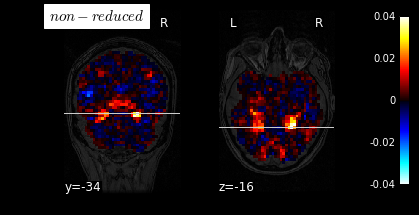

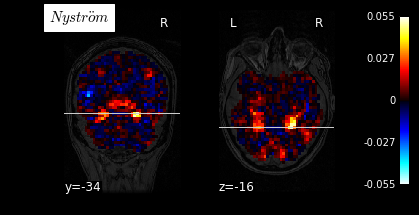

In [6]:
from nilearn.plotting import plot_stat_map

bg_img = data_files['anat'][0]

plot_stat_map(raw_coef, display_mode='yz', bg_img=bg_img, title=r'$non-reduced$', cut_coords=(-34, -16))

plot_stat_map(nys_coef, display_mode='yz', bg_img=bg_img, title=r'$Nystr\"om$', cut_coords=(-34, -16))

from scipy.stats import pearsonr

raw_masked = masker.transform(raw_coef).squeeze()
nys_masked = masker.transform(nys_coef).squeeze()

correlation = pearsonr(raw_masked, nys_masked)[0]

print("correlation %.4f" % correlation)

**Summary:** 
* Result is consistent: High correlation of the maps 
* Reducing the computaion time: High speedup